In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
import os
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Load .npz file from Drive
data = np.load("/content/drive/MyDrive/lulc_patches_labels_planet.npz")
X = data['patches'][:,:,:,:3]  # Shape: (N, H, W, C) or (N, C, H, W)
y = data['labels']   # Shape: (N,)

In [13]:
X.shape

(196, 224, 224, 3)

In [18]:
np.unique(y)

array([  0, 127, 255], dtype=uint8)

In [2]:
label_map = {0: 0, 127: 1, 255: 2}
# Apply the mapping to the 'y' array
y = np.array([label_map[label] for label in y])

# Now 'y' contains labels 0, 1, and 2
# Verify the change
print(np.unique(y))

[0 1 2]


In [3]:
class PatchDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        label = int(self.y[idx])

        # Convert to float and normalize
        image = image.astype(np.float32) / 255.0
        #image = np.transpose(image, (2, 0, 1))  # HWC → CHW
        #image = torch.tensor(image, dtype=torch.float)

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
# Augmentation and preprocessing
input_size = 456  # for EfficientNet-B0
# transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize((input_size, input_size)),
#     transforms.ToTensor(),
# ])
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((input_size, input_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor()
])

# Create dataset and dataloaders
dataset = PatchDataset(X, y, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=2,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2)
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data,device):
  if isinstance(data,(list,tuple)):
    return [to_device(x,device) for x in data]
  else:
    return data.to(device,non_blocking=True)

class DeviceDataloader():
  def __init__(self,device,dl):
    self.dl=dl
    self.device=device

  def __iter__(self):
    for batch in self.dl:
      yield to_device(batch,self.device)

  def __len__(self):
    return len(self.dl)

device=get_default_device()
train_dl=DeviceDataloader(device,train_loader)
test_dl=DeviceDataloader(device,val_loader)
device

device(type='cuda')

In [5]:
model = models.efficientnet_b5(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 3)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B5_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
opt=torch.optim.Adam(model.parameters(),lr=1e-3)
#from torch.optim.lr_scheduler import OneCycleLR
criterion = nn.CrossEntropyLoss()
#scheduler = OneCycleLR(opt, max_lr=1e-3, epochs=50, steps_per_epoch=len(train_dl))
train_epoch_losses=[]
test_epoch_losses=[]
best_loss=1
for epoch in range(100):  # Set the number of epochs
    model.train()
    train_epoch_loss = 0
    test_epoch_loss=0
    for images, label in train_dl:
        # Forward pass
        outputs = model(images)
        loss=criterion(outputs, label)
        train_epoch_loss += loss.item()

        # Backward pass
        opt.zero_grad()
        loss.backward()
        opt.step()
        #scheduler.step()
    train_epoch_losses.append(train_epoch_loss/len(train_dl))
    print(f"Epoch {epoch+1}, Train Loss: {train_epoch_loss/len(train_dl)}")

    for images, label in test_dl:
        model.eval()
        with torch.no_grad():
            outputs = model(images)
            loss = criterion(outputs, label)
            test_epoch_loss += loss.item()
    test_epoch_losses.append(test_epoch_loss/len(test_dl))
    print(f"Test Loss: {test_epoch_loss/len(test_dl)}")
    if test_epoch_loss/len(test_dl)<best_loss:
      best_loss=test_epoch_loss/len(test_dl)
      torch.save(model.state_dict(),f"/content/drive/MyDrive/best5_planet.pt")

Epoch 1, Train Loss: 0.35119204614311456
Test Loss: 1.7295177698135376
Epoch 2, Train Loss: 0.35012105787172915
Test Loss: 4.735775756835937
Epoch 3, Train Loss: 0.3230717906728387
Test Loss: 5.780645108222961
Epoch 4, Train Loss: 0.15126556321047246
Test Loss: 11.494493675231933
Epoch 5, Train Loss: 0.18607641947455705
Test Loss: 3.174076700210571
Epoch 6, Train Loss: 0.13825233662500977
Test Loss: 0.43521713763475417
Epoch 7, Train Loss: 0.14396609963150694
Test Loss: 4.1897591143846515
Epoch 8, Train Loss: 0.21207051076926292
Test Loss: 4.734294897317886
Epoch 9, Train Loss: 0.09034090570639819
Test Loss: 1.4952952816944163
Epoch 10, Train Loss: 0.14230196857824923
Test Loss: 1.6703738091804552
Epoch 11, Train Loss: 0.09135590866208076
Test Loss: 1.1759343926190922
Epoch 12, Train Loss: 0.04413866874529049
Test Loss: 1.4517354556068311
Epoch 13, Train Loss: 0.07524512206437066
Test Loss: 0.5536921769031323
Epoch 14, Train Loss: 0.05836958417203277
Test Loss: 0.6138077937182971
Epoch

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have these lists:
# train_epoch_loss = [train_loss_epoch1, train_loss_epoch2, ...]
# test_epoch_loss = [test_loss_epoch1, test_loss_epoch2, ...]

epochs = range(1, 101)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_epoch_losses, 'b-o', label='Training Loss')
plt.plot(epochs, test_epoch_losses, 'r-o', label='Test Loss')
plt.title('Training and Test Loss over Epochs for EfficientNetB4')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
y_true = []
y_pred = []
model.load_state_dict(torch.load("/content/drive/MyDrive/best4.pt"))
model.eval()
for images, labels in test_dl:
    # images are already on the correct device due to DeviceDataloader
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    # Move labels to CPU before converting to numpy
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=["Class 0", "Class 1"]))

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        36
     Class 1       1.00      1.00      1.00        16

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52



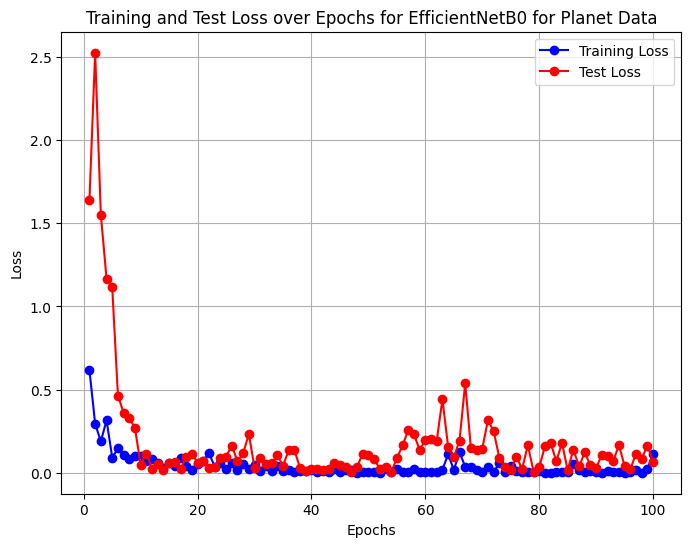

In [7]:
import matplotlib.pyplot as plt

# Assuming you have these lists:
# train_epoch_loss = [train_loss_epoch1, train_loss_epoch2, ...]
# test_epoch_loss = [test_loss_epoch1, test_loss_epoch2, ...]

epochs = range(1, 101)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_epoch_losses, 'b-o', label='Training Loss')
plt.plot(epochs, test_epoch_losses, 'r-o', label='Test Loss')
plt.title('Training and Test Loss over Epochs for EfficientNetB0 for Planet Data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
y_true = []
y_pred = []
model.load_state_dict(torch.load("/content/drive/MyDrive/best_planet.pt"))
model.eval()
for images, labels in test_dl:
    # images are already on the correct device due to DeviceDataloader
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    # Move labels to CPU before converting to numpy
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=["Class 0", "Class 1", "Class 2"], labels=[0,1,2]))

              precision    recall  f1-score   support

     Class 0       1.00      0.96      0.98        28
     Class 1       0.92      1.00      0.96        12

    accuracy                           0.97        40
   macro avg       0.96      0.98      0.97        40
weighted avg       0.98      0.97      0.98        40



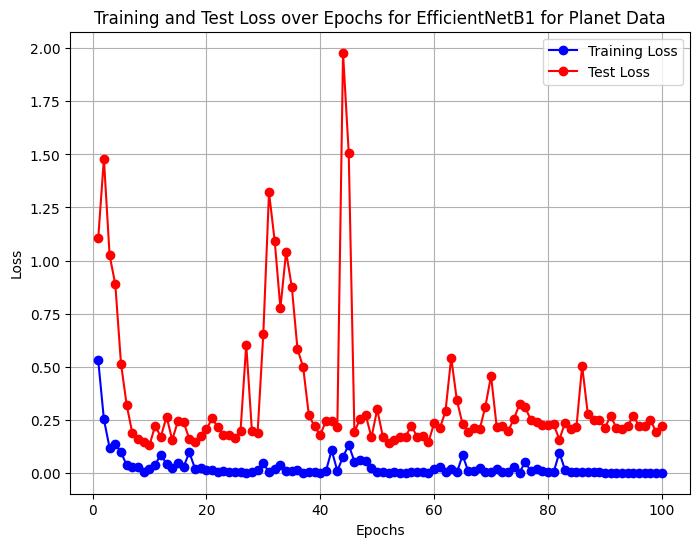

In [13]:
import matplotlib.pyplot as plt

# Assuming you have these lists:
# train_epoch_loss = [train_loss_epoch1, train_loss_epoch2, ...]
# test_epoch_loss = [test_loss_epoch1, test_loss_epoch2, ...]

epochs = range(1, 101)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_epoch_losses, 'b-o', label='Training Loss')
plt.plot(epochs, test_epoch_losses, 'r-o', label='Test Loss')
plt.title('Training and Test Loss over Epochs for EfficientNetB1 for Planet Data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
y_true = []
y_pred = []
model.load_state_dict(torch.load("/content/drive/MyDrive/best1_planet.pt"))
model.eval()
for images, labels in test_dl:
    # images are already on the correct device due to DeviceDataloader
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    # Move labels to CPU before converting to numpy
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=["Class 0", "Class 1", "Class 2"]))

              precision    recall  f1-score   support

     Class 0       0.96      1.00      0.98        27
     Class 1       1.00      1.00      1.00        12
     Class 2       0.00      0.00      0.00         1

    accuracy                           0.97        40
   macro avg       0.65      0.67      0.66        40
weighted avg       0.95      0.97      0.96        40



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


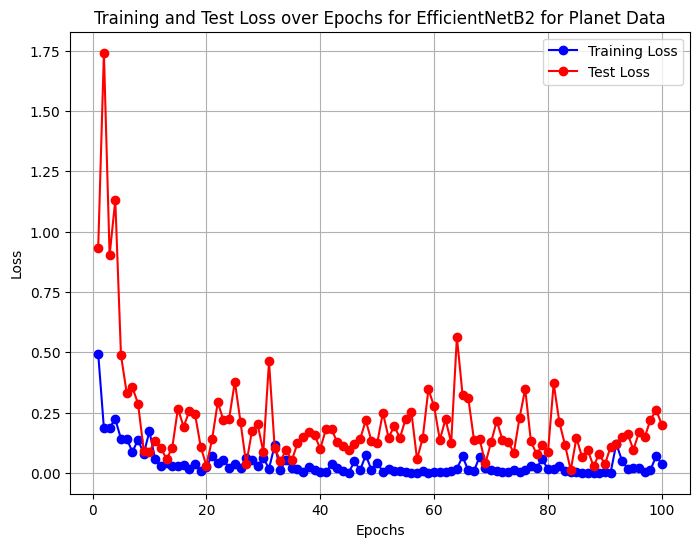

In [19]:
import matplotlib.pyplot as plt

# Assuming you have these lists:
# train_epoch_loss = [train_loss_epoch1, train_loss_epoch2, ...]
# test_epoch_loss = [test_loss_epoch1, test_loss_epoch2, ...]

epochs = range(1, 101)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_epoch_losses, 'b-o', label='Training Loss')
plt.plot(epochs, test_epoch_losses, 'r-o', label='Test Loss')
plt.title('Training and Test Loss over Epochs for EfficientNetB2 for Planet Data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
y_true = []
y_pred = []
model.load_state_dict(torch.load("/content/drive/MyDrive/best2_planet.pt"))
model.eval()
for images, labels in test_dl:
    # images are already on the correct device due to DeviceDataloader
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    # Move labels to CPU before converting to numpy
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=["Class 0", "Class 1", "Class 2"], labels=[0,1,2]))

              precision    recall  f1-score   support

     Class 0       0.97      1.00      0.98        28
     Class 1       1.00      0.92      0.96        12
     Class 2       0.00      0.00      0.00         0

    accuracy                           0.97        40
   macro avg       0.66      0.64      0.65        40
weighted avg       0.98      0.97      0.97        40



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

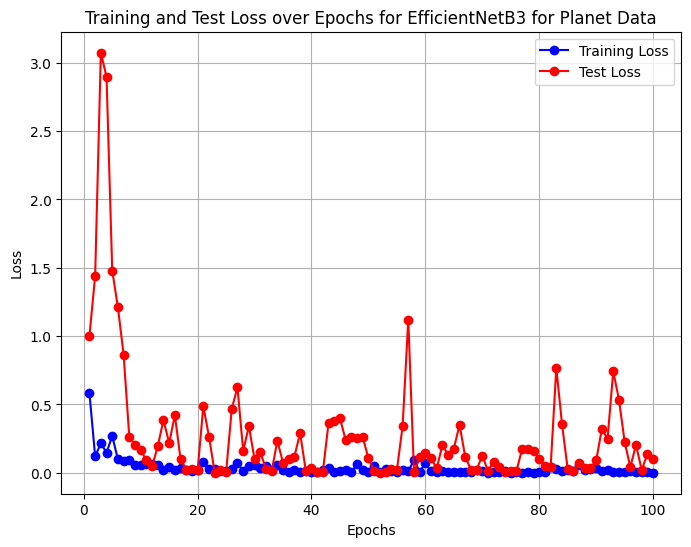

In [25]:
import matplotlib.pyplot as plt

# Assuming you have these lists:
# train_epoch_loss = [train_loss_epoch1, train_loss_epoch2, ...]
# test_epoch_loss = [test_loss_epoch1, test_loss_epoch2, ...]

epochs = range(1, 101)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_epoch_losses, 'b-o', label='Training Loss')
plt.plot(epochs, test_epoch_losses, 'r-o', label='Test Loss')
plt.title('Training and Test Loss over Epochs for EfficientNetB3 for Planet Data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
y_true = []
y_pred = []
model.load_state_dict(torch.load("/content/drive/MyDrive/best3_planet.pt"))
model.eval()
for images, labels in test_dl:
    # images are already on the correct device due to DeviceDataloader
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    # Move labels to CPU before converting to numpy
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=["Class 0", "Class 1", "Class 2"], labels=[0,1,2]))

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        26
     Class 1       1.00      1.00      1.00        14
     Class 2       0.00      0.00      0.00         0

    accuracy                           1.00        40
   macro avg       0.67      0.67      0.67        40
weighted avg       1.00      1.00      1.00        40



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

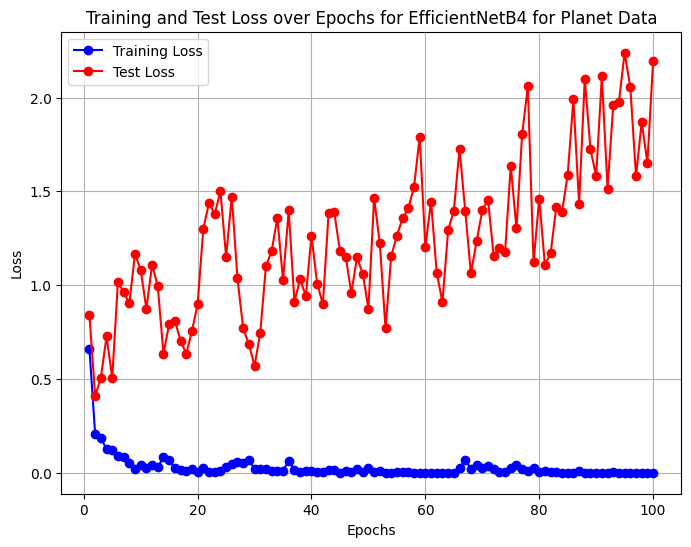

In [7]:
import matplotlib.pyplot as plt

# Assuming you have these lists:
# train_epoch_loss = [train_loss_epoch1, train_loss_epoch2, ...]
# test_epoch_loss = [test_loss_epoch1, test_loss_epoch2, ...]

epochs = range(1, 101)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_epoch_losses, 'b-o', label='Training Loss')
plt.plot(epochs, test_epoch_losses, 'r-o', label='Test Loss')
plt.title('Training and Test Loss over Epochs for EfficientNetB4 for Planet Data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
y_true = []
y_pred = []
model.load_state_dict(torch.load("/content/drive/MyDrive/best4_planet.pt"))
model.eval()
for images, labels in test_dl:
    # images are already on the correct device due to DeviceDataloader
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    # Move labels to CPU before converting to numpy
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=["Class 0", "Class 1", "Class 2"], labels=[0,1,2]))

OutOfMemoryError: CUDA out of memory. Tried to allocate 106.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 18.12 MiB is free. Process 237209 has 14.72 GiB memory in use. Of the allocated memory 14.47 GiB is allocated by PyTorch, and 130.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

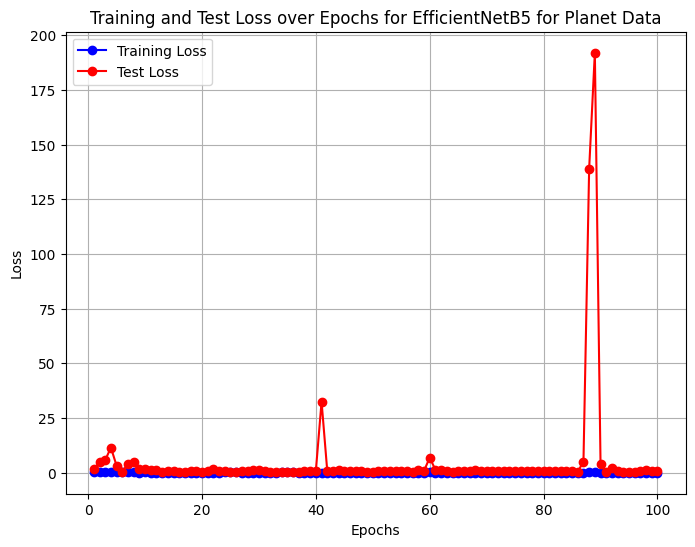

In [7]:
import matplotlib.pyplot as plt

# Assuming you have these lists:
# train_epoch_loss = [train_loss_epoch1, train_loss_epoch2, ...]
# test_epoch_loss = [test_loss_epoch1, test_loss_epoch2, ...]

epochs = range(1, 101)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_epoch_losses, 'b-o', label='Training Loss')
plt.plot(epochs, test_epoch_losses, 'r-o', label='Test Loss')
plt.title('Training and Test Loss over Epochs for EfficientNetB5 for Planet Data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
y_true = []
y_pred = []
model.load_state_dict(torch.load("/content/drive/MyDrive/best5_planet.pt"))
model.eval()
for images, labels in test_dl:
    # images are already on the correct device due to DeviceDataloader
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    # Move labels to CPU before converting to numpy
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=["Class 0", "Class 1", "Class 2"], labels=[0,1,2]))

              precision    recall  f1-score   support

     Class 0       1.00      0.96      0.98        26
     Class 1       0.93      1.00      0.97        14
     Class 2       0.00      0.00      0.00         0

    accuracy                           0.97        40
   macro avg       0.64      0.65      0.65        40
weighted avg       0.98      0.97      0.98        40



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me